# PlaygroundML
---
# 3. Kernel Ridge Regression

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

from kernel_ridge_regression import MyGaussianKernelRidgeRegression, split_dataset, KRR_cross_validation, plot_contour, plot_parameter_surface

A kernel function is defined as $K(\mathbf{x},\mathbf{x}') = \langle \mathbf{\phi}(\mathbf{x}),\mathbf{\phi}(\mathbf{x}') \rangle$ for some feature map $\mathbf{\phi}(\mathbf{x})$, and the corresponding kernel matrix $\mathbf{K}$ has entries $K_{ij} = K(\mathbf{x}_i, \mathbf{x}_j)$. In the dual representation, the predictor trained on the dataset $\mathcal{D} = \{(\mathbf{x}_i,y_i)\}_{1\leq i \leq l}$ is given by
$$
    \hat{y}(\mathbf{x}) = \sum_{i=1}^l \alpha_i^*  K(\mathbf{x}_i, \mathbf{x})
$$
The empirical error with a regularization term is minimized to give the following solution for $\mathbf{\alpha}^*$:
$$
    \begin{split}
        \mathbf{\alpha}^* &= \operatorname{arg}\underset{\mathbf{\alpha}\in\R^l}{\operatorname{min}}\left\{\frac{1}{l}(\mathbf{K}\mathbf{\alpha} - \mathbf{y})^\top(\mathbf{K}\mathbf{\alpha} - \mathbf{y}) + \gamma\mathbf{\alpha}^\top\mathbf{K}\mathbf{\alpha} \right\}\\
        \\
        &= (\mathbf{K} + \gamma l\mathbf{I}_l)^{-1}\mathbf{y}
    \end{split}
$$
This method is known as *kernel ridge regression*, and the presence of kernels allows us to make use of infinite dimensional feature spaces, since we only ever evaluate inner products between images of the data in the feature space (this is called the *kernel trick*).

## 3.1 Kernel ridge regression with the Gaussian kernel

Here, we use the Gaussian kernel (which is an inner product over an infinite-dimensional feature space) to implement kernel ridge regression:
$$
    K(\mathbf{x}_i,\mathbf{x}_j) = \exp\left(-\frac{\| \mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2}\right)
$$
The kernel hyperparameters can be determined by a method called *cross-validation*, where the training data is split into $k$ folds, and the ridge regressor is trained on all but one of the folds, and tested on the remaining (validation) fold. This is repeated $k$ times such that each fold serves as the validation fold once.

For this example, we perform kernel ridge regression on data from `data/boston_housing.csv`, which contains data on housing in different towns in Boston. The hyperparameters took values $\gamma = \{2^{-40},2^{-39},\ldots,2^{-36}\}$ and $\sigma = \{2^7,2^{7.5},\ldots,2^{12.5},2^{13}\}$. The train and test sets were generated from a random $2/3$, $1/3$ split of the Boston housing data, and kernel ridge regression (KRR) using five-fold cross-validation was performed on the training set to determine the optimal values of the hyperparameters $\gamma$ and $\sigma$ for each run (the pair $(\gamma,\sigma)$ that yields the lowest mean MSE on the validation set). KRR was then run on the whole training set to compute the weights $\mathbf{\alpha}^*$ and corresponding train/test MSEs. Results were averaged over 20 runs.


### 3.1.1 Cross-validation
Here we run 5-fold cross-validation the Boston housing data for a range of values for $\sigma$ and $\gamma$, and plot the resulting 'MSE surface'.

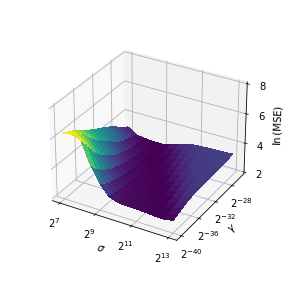

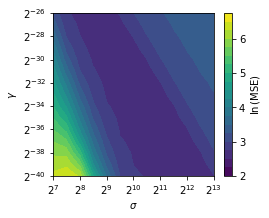

In [9]:
boston_data = np.loadtxt('data/boston_housing.csv', delimiter=',', skiprows=1)
train_frac = 2/3

# Define gammas and sigmas
gammas = 2.0 ** np.arange(-40, -25)
sigmas = 2.0 ** np.arange(7, 13.5, 0.5)

# Split data into training and test sets
train_set, test_set = split_dataset(boston_data, train_frac)
X_train = train_set[:, :-1]
y_train = train_set[:, -1]
X_test = test_set[:, :-1]
y_test = test_set[:, -1]

# Perform 5-fold cross-validation to find best hyperparameters
best_gamma, best_sigma, parameter_MSEs = KRR_cross_validation(X_train, y_train, gammas, sigmas, k_validation=5)

# Plot the parameter surface and contour plot
plot_parameter_surface(parameter_MSEs, gammas, sigmas)
plot_contour(parameter_MSEs, gammas, sigmas)

### 3.1.2 Perform kernel ridge regression
Here we compute the MSE averaged over 20 runs, where we perform 5-fold cross-validation each run to determine the optimal hyperparameters.

In [14]:
n_runs = 20
train_MSEs = []
test_MSEs = []

# Perform 20 runs of KRR with the best hyperparameters
for i in range(n_runs):
    # Split data into training and test sets
    train_set, test_set = split_dataset(boston_data, train_frac)
    X_train = train_set[:, :-1]
    y_train = train_set[:, -1]
    X_test = test_set[:, :-1]
    y_test = test_set[:, -1]

    # Perform 5-fold cross-validation to find best hyperparameters
    i_best_gamma, i_best_sigma, parameter_MSEs = KRR_cross_validation(X_train, y_train, gammas, sigmas, k_validation=5)

    KRR = MyGaussianKernelRidgeRegression(gammas[i_best_gamma], sigmas[i_best_sigma])
    KRR.fit(X_train, y_train)
    train_MSEs.append(KRR.mse(X_train, X_train, y_train))
    test_MSEs.append(KRR.mse(X_train, X_test, y_test))

print(f'Train: MSE = {np.mean(train_MSEs)}')
print(f'Test: MSE = {np.mean(test_MSEs)}')

Train: MSE = 7.22725073256039
Test: MSE = 13.21174014478559
